## Modul

Modul yang digunakan dalam script ini dapat dilihat pada cell berikut. Jika terdapat pesan error bahwa modul tidak tersedia, dapat dilakukan instalasi terlebih dahulu dengan menggunakan `conda`

```{python}
!conda install <module name>
```

Atau bisa menggunakan `pip`

```{python}
!pip install <module name>
```

Instalasi menggunakan `pip` hendaknya dilakukan jika modul tidak tersedia dalam repository `conda`.

In [1]:
# !conda install cdo python-cdo

In [2]:
import os
import shutil
#import sys
#import json
#import time
#import base64
#import requests

from datetime import datetime

#from IPython.core.display import HTML

from getpass import getpass

import warnings
warnings.filterwarnings('ignore')

import hda
import gc

import xarray as xr
import numpy as np
import cf_xarray

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

#import cartopy
from cartopy import crs as ccrs

import colormaps as cmo

from rich.jupyter import print
from tqdm.autonotebook import tqdm



In [3]:
download_dir = os.path.join(os.path.expanduser('~'),"edskywalker", "downloaded-data")
result_dir = os.path.join(os.path.expanduser('~'),"edskywalker","processed-data")

os.makedirs(download_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

print(download_dir)

/home/jovyan/edskywalker/downloaded-data

## Input `username` dan `password` 

Untuk mengakses data WEKEO, Anda perlu memiliki akun terlebih dahulu. Silakan pelajari mengenai pembuatan akun terlebih dahulu di [sini](https://help.wekeo.eu/en/articles/9389186-how-to-create-a-wekeo-account). 

In [4]:
user = r'edskywalker' #input("Enter your name: ")
passw = r'padangLua103#' #getpass("Enter your password: ")

c = hda.Client(hda.Configuration(user=user, password=passw))

## Input *Data Query*

Masukkan parameter terkait dengan jenis data yang diinginkan serta lokasi dan waktunya.

`Dataset` adalah dataset-id. Value yang tepat bisa ditemukan di 

Untuk data Sentinel-3 OLCI, yang tersedia adalah sebagai berikut:

- `EO:EUM:DAT:SENTINEL-3:0556` &rarr; **2016-04-25** -- **28-04-2021**
- `EO:EUM:DAT:SENTINEL-3:OL_2_WFR___` &rarr; **2021-04-29** -- **2023-12-31**

Sentinel-3 juga tersedia dalam 2 jenis satelit, `Sentinel-3A` dan `Sentinel-3B`. Jika pilihan ini tidak diisi, pada `query` akan terpilih semua satelit. Perlu dicatat bahwa Sentinel-3B tersedia mulai tanggal **2018-05-18**.

In [5]:
query = {
  "dataset_id": "EO:EUM:DAT:SENTINEL-3:OL_2_WFR___", #input("Dataset: "), 
  "dtstart": "2023-09-01T00:00:00.000Z", #input("Time start: "),
  "dtend": "2023-09-08T00:00:00.000Z", #input("Time end: "),
  "bbox": [
    106.33442417084652, #float(input("West bound: ")), #106.33442417084652,
    -6.226519426392115, #float(input("South bound: ")), #-6.226519426392115,
    107.12675355792621, #float(input("East bound: ")), #107.12675355792621,
    -5.321432926835288 #float(input("North bound: ")), #-5.321432926835288
  ],
  "sat": "Sentinel-3A",# input("Satellite: "), #"Sentinel-3B",
  "type": "OL_2_WFR___",
  "timeliness": "NT",
  "itemsPerPage": 200,
  "startIndex": 0
}


In [6]:
search_result = c.search(query)
print(search_result)


SearchResults[items=4,volume=1.8GB]

In [7]:
for res in search_result.results:
    file_id = res['id']
    print(f"Found: {file_id}")

Found: S3A_OL_2_WFR____20230907T022920_20230907T023220_20230908T163205_0180_103_103_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230906T025530_20230906T025830_20230907T141846_0179_103_089_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230903T023303_20230903T023603_20230904T151056_0179_103_046_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230902T025914_20230902T030214_20230903T140720_0179_103_032_3060_MAR_O_NT_003.SEN3

In [8]:
data_id = search_result[0].results[0]['id']

#print(search_result[0].results[0]['properties'])

start = datetime.strptime(search_result[0].results[0]['properties']['startdate'], '%Y-%m-%dT%H:%M:%S%fZ')
end = datetime.strptime(search_result[0].results[0]['properties']['enddate'], '%Y-%m-%dT%H:%M:%S%fZ')

timestamp = start + (end - start) / 2

#print(start, end, timestamp)
search_result[0].download()

In [9]:
import zipfile

with zipfile.ZipFile(data_id + '.zip', 'r') as zip_ref:
    zip_ref.extractall(download_dir)
    print(f'Unzipping of product {data_id} finished.')
    os.remove(data_id + '.zip')

Unzipping of product 
S3A_OL_2_WFR____20230907T022920_20230907T023220_20230908T163205_0180_103_103_3060_MAR_O_NT_003.SEN3 finished.

In [10]:
safe_dir = os.path.join(download_dir,data_id)

geo_coords = xr.open_dataset(os.path.join(download_dir,data_id,'geo_coordinates.nc'))
flag_file = xr.open_dataset(os.path.join(download_dir,data_id,'wqsf.nc'))
chl_file = xr.open_dataset(os.path.join(download_dir,data_id,'chl_nn.nc'))

In [11]:
lon = geo_coords.variables['longitude'].data
lat = geo_coords.variables['latitude'].data
flags_data = flag_file.variables['WQSF'].data
chl_nn = chl_file.variables['CHL_NN'].data

In [12]:
def flag_data_fast(list_flag, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    for flag in list_flag:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + 'not present')
    return (flag_data & flag_bits) > 0			


In [13]:
list_flag = ['LAND', 'INLAND_WATER', 'TIDAL', 'COASTLINE', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3', 'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8', 'OCNN_FAIL']

flag_names = flag_file['WQSF'].flag_meanings.split(' ') #flag names
flag_vals = flag_file['WQSF'].flag_masks #flag bit values
flags_data = flag_file.variables['WQSF'].data

flag_mask = flag_data_fast(list_flag, flag_names, flag_vals, flags_data, flag_type='WQSF') # return a numpy array with selected flags

chl_flagged = np.where(flag_mask, np.nan, chl_nn) # return a numpy array of masked chl-a data

In [14]:
dta = xr.Dataset()

dta['longitude'] = xr.DataArray(lon, dims=('rows','columns'))
dta['longitude'].attrs = geo_coords['longitude'].attrs
dta['latitude'] = xr.DataArray(lat, dims=('rows','columns'))
dta['latitude'].attrs = geo_coords['latitude'].attrs

dta['chl_flag'] = xr.DataArray(chl_flagged, dims=('rows','columns'))
dta['chl_flag'].attrs = chl_file['CHL_NN'].attrs

dta = dta.set_coords(['longitude','latitude'])

dta = dta.expand_dims(dim={"time":[timestamp]}, axis=0)

In [15]:
del geo_coords
del chl_file
del flag_file

gc.collect()

41

In [16]:
chl_plot = 10 ** dta['chl_flag']

In [17]:
bbox_str = '106.3,107.1,-6.2,-5.3' 

reggridded = cdo.sellonlatbox(bbox_str, input = dta, returnXDataset = True)

# reggridded = cdo.remapcon(gridfile, input = bounded_dataset, returnXDataset = True)

In [18]:
reggridded.to_netcdf(os.path.join(result_dir , data_id + '.nc'))

regrid = xr.open_dataset(os.path.join(result_dir , data_id + '.nc'))

print(regrid)

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 1, rows: 397, columns: 402)
Coordinates:
  * time       (time) datetime64[ns] 8B 2023-09-07T02:30:31.900000
    longitude  (rows, columns) float64 1MB ...
    latitude   (rows, columns) float64 1MB ...
Dimensions without coordinates: rows, columns
Data variables:
    chl_flag   (time, rows, columns) float32 638kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Jul 05 13:19:53 2024: cdo -O -s -f nc -sellonlatbox,106...
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

In [19]:
chl_plot = 10 ** regrid['chl_flag']

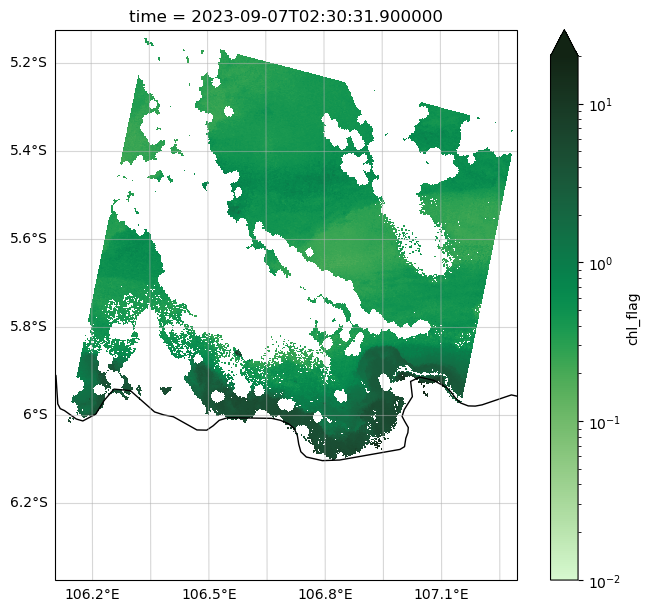

In [20]:
fig, ax = plt.subplots(figsize=[8,6], layout='constrained', subplot_kw=dict(projection=ccrs.Robinson(central_longitude=112.0)))

# ax.add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)
ax.coastlines()
ini = ax.gridlines(draw_labels = True, alpha=0.5)
ini.top_labels = False
ini.right_labels = False

chl_plot.plot(ax=ax, x='longitude', y='latitude', norm=colors.LogNorm(0.01,20), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)

In [21]:
cdo.cleanTempDir()

In [22]:
shutil.rmtree(download_dir)